<a href="https://colab.research.google.com/github/seokhee516/kaggle-practice/blob/main/%EC%BD%94%EB%A1%9C%EB%82%9819%EC%99%80%EC%9D%98_%EC%A0%84%EC%9F%81%EC%97%90%EC%84%9C_%EC%83%9D%EB%AA%85_%EA%B5%AC%ED%95%98%EA%B8%B0_'%EC%82%AC%EB%A7%9D'%EC%97%90_%EB%8C%80%ED%95%9C_insights_%EB%8F%84%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


원본 주소: https://dacon.io/competitions/official/235590/codeshare/949

In [3]:
# 구글 드라이브 경로 설정
cd /content/drive/MyDrive/Colab Notebooks/coronavirusdataset_20200430

/content/drive/MyDrive/Colab Notebooks/coronavirusdataset_20200430


### State of the art: 코로나 19에 대해 현재까지 우리가 알고있는 것
코로나 사망 주요요인
- 연령: 고연령층 사망 위험 높음
- 기저질환: 기저질환 보유자 사망 위험 높음

프로젝트 분석의 초점: **행동적 요인**  
- 연령, 기저질환, 성별 -> 생물학적/인구학적 요인
- 행동적 요인은 통제 범위 넓음
- 사람이 통제할 수 있는, 생명을 구라는 가능성을 높일 수 있는 행동 요인 파악 목적

# 결론 핵심 요약
## 1) 확진자 행동 특성의 네 가지 유형
- 1) **Hypermobile and hypersocial unknowns** (매우 높은 수준의 유동성과 사회성): 감염 경로 파악 어려움, 확진 늦게 받음 
- 2) **Moderate groupies** (유동성 보통, 다소 높은 사회성): 집단 감염 유형. 확진 받기까지 평균 수준 시간
- 3) **Social minimalists** (유동성, 사회성 보통보다 낮음): 직접 접촉 감염. 확진 받기까지 평균 수준 시간
- 4) **Overseas non-essentialists가장** (낮은 수준의 유동성과 사회성): 해외에서 유입. 확진까지 가장 짧은 시간

## 2) 사망 위험과 관련된 주요 요인: 확진받기까지 걸린 시간
확진을 빠르게 받음으로써 사망 위험을 줄이고 생명을 살릴 가능성도 높일 수 있다


# 1. Feature engineering
행동과 관련된 특성/요인: 확진자들의 통제 하에 있는 특성/요인. 확진자들에 선택에 따라 값이 달라지는 특성을 의미

행동패턴 파악을 위해 Cluster 모델 활용 확진자 행동 유형 구분.
- 1) 감염 겸로 유형
- 2) 유동성
- 3) 접촉 정도
- 4) 확진받기까지 걸린 시간

## 1.0. Data prep

In [6]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')

In [7]:
patient = pd.read_csv('PatientInfo.csv')
patient.head(3)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released


In [8]:
print(patient.shape, len(patient.patient_id.unique()))

(3388, 18) 3388


In [9]:
# 질문 : 데이터 분석할때 왜 copy를 해줄까? 얕은 카피
data = patient.copy()

In [10]:
print('the number of unique values in infection_case:', len(data['infection_case'].unique()))
data['infection_case'].unique()

the number of unique values in infection_case: 24


array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Gyeongsan Seorin Nursing Home',
       'Gyeongsan Cham Joeun Community Center',
       'Gyeongsan Jeil Silver Town', 'Bonghwa Pureun Nursing Home',
       'Pilgrimage to Israel', 'Milal Shelter', 'Geochang Church',
       'Changnyeong Coin Karaoke'], dtype=object)

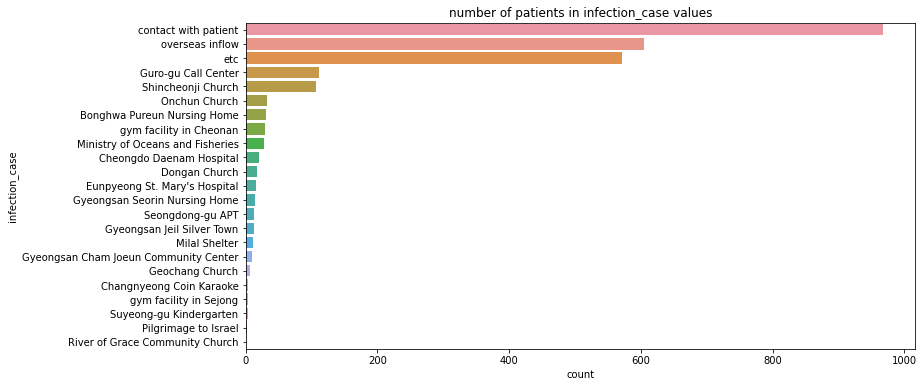

In [13]:
# 의견 : 변수 개수로 비중 확인 + 집단감염 판단
g = data.groupby(['infection_case'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id': 'count'}, inplace = True)

g = g.sort_values('count', ascending = False)
plt.figure(figsize = (12,6))
plt.title('number of patients in infection_case values')
sns.barplot(y = 'infection_case', x= 'count', data = g)
display()

In [14]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = pd.DataFrame(g)

# 방법 : 조건을 통해 index 고르는 방법
infection_case_less_than_5 = g[g['patient_id'] < 5].index.tolist()
g[g.index.isin(infection_case_less_than_5)]

,patient_id
infection_case,
Changnyeong Coin Karaoke,4
Pilgrimage to Israel,2
River of Grace Community Church,1
Suyeong-gu Kindergarten,3
gym facility in Sejong,4


In [15]:
print('original data shape:', data.shape)
data = data[~(data['infection_case'].isin(infection_case_less_than_5))]
print('data shape after slicing: ', data.shape)

original data shape: (3388, 18)
data shape after slicing:  (3374, 18)


In [16]:
data[data['infection_case'].isna()].shape

(768, 18)

In [17]:
# 방법 : 함수와 람다 사용해서 데이터 값 생성하기
def categorisation(x):
  if x == 'overseas inflow':
    y = 'overseas'
  elif x == 'contact with patient':
    y = 'individual'
  elif (x=='etc') | (pd.isna(x)):
    y = 'unknown'
  else:
    y = 'group'
  return y

data['infection'] = data['infection_case'].apply(lambda x: categorisation(x))
print(data.shape)
data.head()

(3374, 19)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual


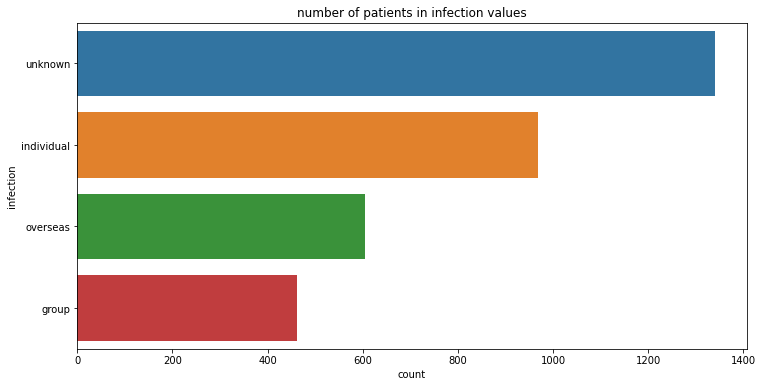

In [20]:
# 방법: 데이터를 새로 만들어서 시각화
g = data.groupby(['infection'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id': 'count'}, inplace = True)

g = g.sort_values('count', ascending= False)

plt.figure(figsize=(12,6))
sns.barplot(y = 'infection', x = 'count', data = g)
plt.title('number of patients in infection values')
display()

## 1.2. 유동성

In [21]:
route = pd.read_csv('PatientRoute.csv')
route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.00,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.62,126.72
1,1000000001,2.00,2020-01-24,Seoul,Jung-gu,hospital,37.57,127.01
2,1000000002,5.00,2020-01-25,Seoul,Seongbuk-gu,etc,37.59,127.02
3,1000000002,5.00,2020-01-26,Seoul,Seongbuk-gu,store,37.59,127.02
4,1000000002,5.00,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.56,127.03


In [22]:
print('the number of unique values in type:', len(route['type'].unique()))
route['type'].unique()

the number of unique values in type: 24


array(['airport', 'hospital', 'etc', 'store', 'public_transportation',
       'restaurant', 'church', 'beauty_salon', 'pharmacy', 'pc_cafe',
       'bank', 'cafe', 'bakery', 'bar', 'gym', 'school',
       'real_estate_agency', 'karaoke', 'post_office', 'gas_station',
       'lodging', 'academy', 'university', 'administrative_area_level_1'],
      dtype=object)

In [23]:
route[route['type'].isna()].shape

(0, 8)

In [24]:
# 의견 (*) : 카테고리 구분. 하이카디널리티 처리할 때 좋을 듯
## categories

leisure = ['library', 'theater', 'cafe', 'bakery', 'beauty_salon',
          'pc_cafe', 'billiards','restaurant', 'bar', 'karaoke']
travel = ['airport', 'lodging']
essential_edu = ['primary_school', 'school', 'university']
non_essential_edu = ['academy']
exercise = ['gym', 'mountain', 'park']
essential_admin = ['administrative_area_level_1', 'governmnet_office', 'post_office']
non_essential_admin = ['police_office', 'bank', 'real_estate_agency']
necessity = ['store', 'public_transportation', 'gas_station']
medical = ['hospital', 'pharmacy']
church = ['church']
etc = ['etc']

In [28]:
# 의견 : 필수 방문 처리. 데이터 전처리 자세함
essential = essential_edu + essential_admin + necessity + medical

def type_group_essen(x):
  group = None
  if x in essential:
    group = 'essential'
  else:
    group = 'non-essential'
  return group

route['route_group_essential'] = route['type'].apply(lambda x: type_group_essen(x))
route = route[['patient_id','type', 'route_group_essential']]
route.head()

,patient_id,type,route_group_essential
0,1000000001,airport,non-essential
1,1000000001,hospital,essential
2,1000000002,etc,non-essential
3,1000000002,store,essential
4,1000000002,public_transportation,essential


In [29]:
# 질문 : unstack
route['route_value'] = 1
g = pd.DataFrame(route.groupby(['patient_id', 'route_group_essential'])['route_value'].count().unstack())
g

route_group_essential,essential,non-essential
patient_id,,
1000000001,1.00,1.00
1000000002,9.00,4.00
1000000003,nan,2.00
1000000004,1.00,nan
1000000005,1.00,nan
...,...,...
6100000086,2.00,2.00
6100000087,6.00,2.00
6100000088,5.00,19.00


In [30]:
g.fillna(0, inplace = True)
g.reset_index(inplace = True)
g = g[['patient_id', 'essential', 'non-essential']]
g.head()

route_group_essential,patient_id,essential,non-essential
0,1000000001,1.00,1.00
1,1000000002,9.00,4.00
2,1000000003,0.00,2.00
3,1000000004,1.00,0.00
4,1000000005,1.00,0.00


In [31]:
data = data.merge(g, left_on = 'patient_id', right_on = 'patient_id', how = 'left')
data.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas,9.00,4.00
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual,0.00,2.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual,1.00,0.00


In [32]:
print(data.shape)
data[(data['essential'].isna()) | (data['non-essential'].isna())].shape

(3374, 21)


(2170, 21)

In [33]:
# 방법 :  근거가 없는 데이터는 판단하지 않고 삭제, notna()
print('original data shape:', data.shape)
data = data[(data['essential'].notna()) & (data['non-essential'].notna())] 
print('data shape after removing missing values in essentail/non-essential:', data.shape)

original data shape: (3374, 21)
data shape after removing missing values in essentail/non-essential: (1204, 21)


## 1.3. 접촉 정도

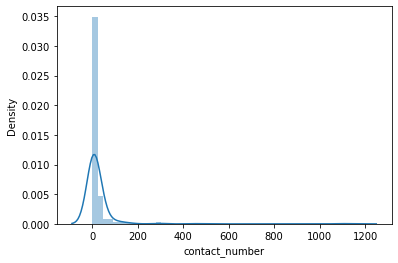

In [34]:
sns.distplot(data['contact_number'])
display()

In [35]:
# 질문 : 접촉이 많은 사람일수록 상대적으로 훨씬 많은 접촉 -> 75%의 값이 훨씬 더 큼?
data['contact_number'].describe()

count    332.00
mean      24.27
std       95.07
min        0.00
25%        2.00
50%        5.00
75%       17.25
max     1160.00
Name: contact_number, dtype: float64

In [36]:
# 의견 : 집단감염의 사례였을 가능성이 있음 outlier 판단 x
# 코로나 바이러스 확산 초창기 확진자 수를 기하급수적으로 늘리는데 기여한 '31번 확진자'
data[data['contact_number'] == 1160]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
764,1200000031,31.00,female,1959.00,60s,Korea,Daegu,NaN,NaN,Shincheonji Church,nan,nan,1160.00,NaN,2020-02-18,NaN,NaN,isolated,group,11.00,5.00


In [37]:
# 접촉 횟수의 값이 없는 사람들은 모두 제거
print('original data shape:', data.shape)
data = data[data['contact_number'].notna()]
print('data shape after removing missing values in contact_number:', data.shape)

original data shape: (1204, 21)
data shape after removing missing values in contact_number: (332, 21)


## 1.4. 확진받기까지 걸린 시간

In [38]:
# 증상이 처음 시작된 날(symptom_onset_date), 확진 날짜(confirmed_date)
print('data shape:', data.shape)
print('missing values in symptom_onset_date:', data[data['symptom_onset_date'].isna()].shape)
print('missing values in confirmed_date:', data[data['confirmed_date'].isna()].shape)

data shape: (332, 21)
missing values in symptom_onset_date: (208, 21)
missing values in confirmed_date: (0, 21)


In [41]:
# 질문 : 왜 이런식으로 만드는지
# 증상이 발현한 날짜의 정보가 없는 확진자들은 모두 제거
data[data['symptom_onset_date'] == ' ']
data['symptom_onset_date'] = np.where((data['symptom_onset_date'] == ' '), None, data['symptom_onset_date'])

print('original data shape: ', data.shape)
data = data[data['symptom_onset_date'].notna()]
print('data excluding missing values in symptom_onset_date: ', data.shape)

original data shape:  (332, 21)
data excluding missing values in symptom_onset_date:  (124, 21)


In [42]:
# 방법 : 문자열 -> datetime 객체로 만듦 strptime()
# 확진받기까지의 시간
def convert_date(x):
    x = pd.datetime.strptime(x, '%Y-%m-%d').date()
    return x

In [43]:
data['symptom_onset_date'] = data['symptom_onset_date'].apply(lambda x : convert_date(x))
data['confirmed_date'] = data['confirmed_date'].apply(lambda x: convert_date(x))

data.head(3)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
13,1000000014,30.00,female,1952.00,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,5.00,1000000013.00,27.00,2020-02-06,2020-02-16,2020-03-12,NaN,released,individual,10.00,3.00


In [44]:
# symptom_onset_date와 confirmed_date 사이의 날짜 차이 'days'
data['days_notice'] = data['confirmed_date'] - data['symptom_onset_date'] 
data['hours_notice'] = data['days_notice'].apply(lambda x: round(x.total_seconds()/3600, 2))
data['days'] = data['hours_notice'].apply(lambda x: int(x/24))
data.head(3)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential,days_notice,hours_notice,days
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00,1 days,24.00,1
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00,4 days,96.00,4
13,1000000014,30.00,female,1952.00,60s,Korea,Seoul,Jongno-gu,NaN,contact with patient,5.00,1000000013.00,27.00,2020-02-06,2020-02-16,2020-03-12,NaN,released,individual,10.00,3.00,10 days,240.00,10


# 2. Building cluster model
## 2.1. Feature transformation

In [45]:
# 행동 특성 추출 클러스터 모델
data_ = data[['patient_id', 
              'days', 
              'contact_number', 
              'essential', 'non-essential', 
              'infection']]
data_.reset_index(drop = True, inplace = True)
print(data_.shape)
data_.head()

(124, 6)


,patient_id,days,contact_number,essential,non-essential,infection
0,1000000001,1,75.00,1.00,1.00,overseas
1,1000000004,4,9.00,1.00,0.00,overseas
2,1000000014,10,27.00,10.00,3.00,individual
3,1000000015,8,8.00,6.00,3.00,group
4,1000000302,1,8.00,1.00,0.00,overseas


### 2.1.2.transformation of categorical variable

In [46]:
# 질문 : 왜 이렇게 만들지... reshape()
# 감염 경로 유형 numeric 변수로 원핫인코딩
encoder = OneHotEncoder(categories = 'auto', sparse=False)
encoder.fit(np.array(data_['infection']).reshape(-1, 1))
inf_dummies = encoder.transform(np.array(data_['infection']).reshape(-1, 1))
dummies = pd.DataFrame(inf_dummies.astype(int), columns = ['infection_' + x for x in encoder.categories_[0]])

data_ = data_.join(dummies)
print(data_.shape)
data_.head()

(124, 10)


,patient_id,days,contact_number,essential,non-essential,infection,infection_group,infection_individual,infection_overseas,infection_unknown
0,1000000001,1,75.00,1.00,1.00,overseas,0,0,1,0
1,1000000004,4,9.00,1.00,0.00,overseas,0,0,1,0
2,1000000014,10,27.00,10.00,3.00,individual,0,1,0,0
3,1000000015,8,8.00,6.00,3.00,group,1,0,0,0
4,1000000302,1,8.00,1.00,0.00,overseas,0,0,1,0


### 2.1.2. scaling

In [47]:
# 인풋값 지정
inputs = ['days', 
          'essential', 'non-essential', 'contact_number',
          'infection_group', 'infection_individual', 'infection_overseas', 'infection_unknown']

X = data_[inputs]
print(X.shape)
X.head()

(124, 8)


,days,essential,non-essential,contact_number,infection_group,infection_individual,infection_overseas,infection_unknown
0,1,1.00,1.00,75.00,0,0,1,0
1,4,1.00,0.00,9.00,0,0,1,0
2,10,10.00,3.00,27.00,0,1,0,0
3,8,6.00,3.00,8.00,1,0,0,0
4,1,1.00,0.00,8.00,0,0,1,0


In [48]:
X = X.values
scaler = StandardScaler()
X = scaler.fit_transform(X)  

## 2.2. Dimensionality reduction using PCA

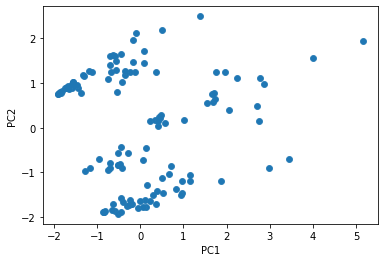

In [49]:
# 의견 + 질문 (*): PCA 어떤 원리로 만들어지는지?
# PCA 차트를 통해 3-4개의 clusters가 파악될 것을 예상?
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

ax = sns.scatterplot(x='PC1', y='PC2', data = principalDF) 
sns.regplot(x=principalDF['PC1'], y=principalDF['PC2'], fit_reg=False)

display()

# 2.3. Clustering

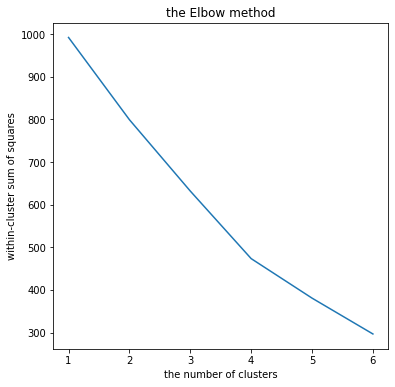

In [50]:
# cluster 개수 별 SSE 를통해 optimal한 clusters의 개수 확인
# 4개 이상일 때 에러가 감소하는 폭이 줄어든 것을 확인
cluster_range = range(1,7)
cluster_errors = []
for n in cluster_range:
    cluster = KMeans(n)
    cluster.fit(X)
    cluster_errors.append(cluster.inertia_)

plt.figure(figsize = (6,6))
plt.plot(cluster_range, cluster_errors)
plt.title('the Elbow method')
plt.xlabel('the number of clusters')
plt.ylabel('within-cluster sum of squares')
display()

In [51]:
# 4개 이상일 때 어떤 현상이 나타나는지 먼저 확인. 5개
# 방법 : KMeans 클러스터 시각화
km = KMeans(n_clusters = 5)
km.fit(X)

centroids = km.cluster_centers_ 
labels= km.labels_
data_['label'] = labels

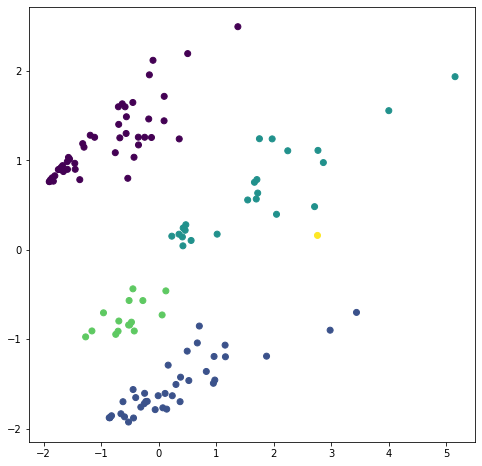

In [52]:
# 한 개 포인트만 구분한 클러스터 존재 -> 4개 최적
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

plt.figure(figsize = (8,8))
plt.scatter('PC1', 'PC2', data = principalDF, c = labels)

display()

In [53]:
data_.groupby(['label'])['patient_id'].count()

label
0    46
1    39
2    23
3    15
4     1
Name: patient_id, dtype: int64

In [55]:
data_[data_['label'] == 4]

,patient_id,days,contact_number,essential,non-essential,infection,infection_group,infection_individual,infection_overseas,infection_unknown,label
62,1300000001,7,450.00,7.00,1.00,overseas,0,0,1,0,4


In [56]:
# 의견 (*) : 위 포인트 다른 네 개의 clusters와 행동 패턴을 공유하지 않음 -> 제거
data_ = data_[data_['patient_id'] != 1300000001]
data_.reset_index(drop = True, inplace = True)

X = data_[inputs]
print('X shape:', X.shape) 

X = X.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

km = KMeans(n_clusters = 4)
km.fit(X)

centroids = km.cluster_centers_ 
labels= km.labels_
data_['label'] = labels

X shape: (123, 8)


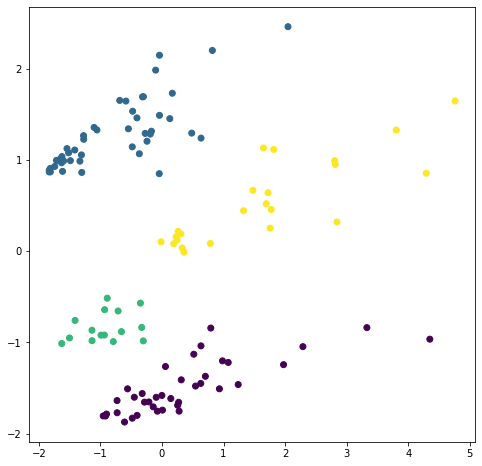

In [57]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

plt.figure(figsize = (8,8))
plt.scatter('PC1', 'PC2', data = principalDF, c = labels)

display()

# 3. Cluster 분석 결과: 코로나19 확진자들의 네 가지 유형

In [60]:
# 질문 (*) : results_.csv 파일 구할 수 없는지? 직접 처리할 수는 없는지
# 위의 분석 결과에 더해 행동 특성들의 실제 값을 보다 readable하게 제작해 저장한 데이터셋을 불러와 활용
# data_ = pd.read_csv('results_.csv')
# data_.head(2)

---
아래 내용은 원본 결과보면서 의견 추가

원본 주소: https://dacon.io/competitions/official/235590/codeshare/949

In [ ]:
# 클러스터 이름 설정
cluster_dic = {}
for label, name in zip(data_['label'], data_['label_name']):
    cluster_dic[label] = name

# 클러스터 색상 설정
colour = {0: '#EF3D59',
          1: '#E17A47',
          2: '#EFC958',
          3: '#4AB19D'} 

In [ ]:
# 의견 (*) : 시각화 plotly.express as px 활용 matplotlib, seaborn 외에 새로운 시각화 툴
# 차원 축소 scatter plot
layout = { 
  "title": "Fours types of patients by behavioural patterns",  
  "plot_bgcolor": "rgb(252,252,252)"
}
 
fig = px.scatter(data_, x = 'PC1', y = 'PC2'
                 , color = 'label_name'
                 , hover_data = ['infection_route', 'promptness_of_diagnosis', 'essential_mobility', 'non_essential_mobility']
                 , color_discrete_sequence = ['#4AB19D', '#EFC958', '#E17A47', '#EF3D59']
                 , height= 600)

fig.update(layout = layout)  
fig.show()

## 3.1. 감염 경로
- 1) Hypermobile & hypersocial unknowns: 모두 감염 경로가 알려지지 않음
- 2) Moderate groupies: 모두 집단 감염자
- 3) Social minimalists: 모두 개인 감염자
- 4) Overseas non-essentialists: 모두 해외 유입

In [ ]:
# 의견 (*) : FacetGrid 다양한 범주형 값을 가지는 데이터 시각화 
# 방법 : map() 이용 그리드 객체에 전달
g = sns.FacetGrid(data_, col = 'label',  height = 6, sharey = True, sharex = True, 
                  hue= 'label', palette=colour)

g.map(sns.countplot, "infection", order = ['unknown', 'group', 'individual', 'overseas'])
  
ax0, ax1, ax2, ax3 = g.axes[0]

for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.set_title(cluster_dic[i]) 
display()

## 3.2. 유동성
확진자 수가 많고 적음에 따라 유형별 총 방문 횟수 역시 높고 낮아질 수 있음  
유형별 총 이동 횟수에 유형에 속하는 확진자 수를 나누어 '유형별 인당 이동 횟수'를 구함


In [ ]:
g1 = pd.DataFrame(data_.groupby(['label', 'patient_id'])['essential'].sum())
g2 = pd.DataFrame(data_.groupby(['label', 'patient_id'])['non-essential'].sum())
g = g1.merge(g2, left_index = True, right_index = True)
g.reset_index(inplace = True)
g['label'] = g['label'].astype('category')
# 방법 : 유형에 속하는 확진자 수를 melt를 통해 구함
g_ = g.melt(id_vars= ['label', 'patient_id'], value_vars=['essential', 'non-essential'],
        var_name='route', value_name='route_sum')
# 방법 : 유형별 총 이동 횟수를 groupby를 통해 구함 
g__ = g_.groupby(['label','route'])['route_sum'].mean()
g__ = pd.DataFrame(g__)
g__ = g__.reset_index()

In [ ]:
g_sum = g__.groupby('label')['route_sum'].sum()
g_sum = pd.DataFrame(g_sum)

plt.figure(figsize = (10,8))
ax = sns.barplot(g_sum.index, g_sum['route_sum'], palette = colour)

xlabels = [v for k, v in sorted(cluster_dic.items())]  
xlabels[0] = 'Hypermobile & hypersocial\nunknowns'

ax.set_xticklabels(xlabels, fontsize = 10)
ax.set(xlabel='Cluster', ylabel='Total number of visits(per person)') 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.axhline(g_sum['route_sum'].mean(), ls='--', color = '#AF4BCE') 
ax.text(0.7, 0.74, 'mobility on average',
    horizontalalignment='left',
    size = '15', color = '#AF4BCE',transform = ax.transAxes)

display()

In [ ]:
avg_ess = g__.groupby('route')['route_sum'].mean().values[0]
avg_non = g__.groupby('route')['route_sum'].mean().values[1]

g = sns.FacetGrid(g__, col = 'label', height = 8, sharey = True, hue= 'label', palette=colour)
g.map(sns.barplot, 'route', 'route_sum') 

ax0, ax1, ax2, ax3 = g.axes[0]

for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.set_title(cluster_dic[i])
    ax.axhline(avg_ess, ls='--', color = '#20639B') 
    ax.axhline(avg_non, ls='--', color = '#AF4BCE') 
    if i == 3:
        ax.text(0.32, 0.74, 'non-essential mobility on average',
        horizontalalignment='left',
            size = '20', color = '#AF4BCE',transform = ax.transAxes)
        ax.text(0.4, 0.64, 'essential mobility on average',
        horizontalalignment='left',
            size = '20', color = '#20639B',transform = ax.transAxes)

display()

## 3.3. 접촉 정도
첫번째 유형 가장 높고, 두번째 유형이 두번째로 높은 반면, 세번째와 네번째 유형은 훨씬 낮은 수준의 접촉 정도

In [ ]:
g = data_.groupby(['label']).describe()['contact_number']
g = g.reset_index()

plt.figure(figsize = (10,8))

ax = sns.barplot(g.index, g['mean'], palette = colour)

ax.set_xticklabels(xlabels, fontsize = 10)
ax.set(xlabel='Cluster', ylabel='The number of contacts with other people') 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.axhline(data_['contact_number'].mean(), ls='--', color = '#AF4BCE') 
ax.text(0.6, 0.7, 'contact numbers on average',
    horizontalalignment='left',
    size = '15', color = '#AF4BCE',transform = ax.transAxes)

display()

# 3.4. 확진받기까지 걸린 시간
첫번째 유형이 확진받기까지 가장 오랜 시간, 두번째와 세번째 유형은 첫번째 유형보다는 빨리 확진, 네번째 유형은 가장 빨리 확진

In [ ]:
g = data_.groupby(['label']).describe()['days']
g = g.reset_index()

plt.figure(figsize = (10,8))

ax = sns.barplot(g.index, g['mean'], palette = colour)

xlabels = [v for k, v in sorted(cluster_dic.items())]  
xlabels[0] = 'Hypermobile & hypersocial\nunknowns'

ax.set_xticklabels(xlabels, fontsize = 10)
ax.set(xlabel='Cluster', ylabel='Promptness of diagnosis (days)') 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# 방법 (*) : axhline 위치 mean을 통해 중간에 지정 (했었나?)
ax.axhline(data_['days'].mean(), ls='--', color = '#AF4BCE') 
ax.text(0.5, 0.74, 'promptness of diagnosis on average',
    horizontalalignment='left',
    size = '15', color = '#AF4BCE',transform = ax.transAxes)


display()

## 3.5. 유형 별 사망자/회복자의 분포
사망자가 첫번째 유형에서만 나타남

In [ ]:
g = sns.FacetGrid(data_, col = 'label', height = 8, sharey = True, sharex = True,
                  hue= 'label', palette=colour)
g.map(sns.countplot, "state", order = data_['state'].unique().tolist())

ax0, ax1, ax2, ax3 = g.axes[0]

for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.set_title(cluster_dic[i]) 
display()

In [ ]:
# 의견 (*) : plotly.graph_objects as go  / plotly 여러가지 있음
# 유형별 행동 특성을 직관적으로 파악
categories = ['non-essential mobility',
              'overall mobility',
              'infection route',   
              'death', 
              'diagnosis time',
              'number of contacts']

figure = go.Figure()

figure.add_trace(go.Scatterpolar(
      r=[1.28993026770945,1.55298600830023,-0.0998503330556044,1.73205080756887,1.45031686418962,1.42715396821808],
      theta=categories,
      fill='toself',
    line=dict(width=0.5, color = 'rgba(239,61,89,.2)'),
      name='Hypermobile & hypersocial unknowns'
)) 

figure.add_trace(go.Scatterpolar(
      r=[0.607732509740207,0.130826373345411,-0.0998503330556044,-1.37615293363446,-0.0412021836417504,0.449380661272821],
      theta=categories,
      fill='toself',
    line=dict(width=0.5, color = 'rgba(225,122,71,0.4)'),
    name='Moderate groupies'
))
 
figure.add_trace(go.Scatterpolar(
      r=[-1.23708396251465,-0.564862106091365,-0.0998503330556044,-1.37615293363446,-0.0329617469134004,-0.955551186332868],
      theta=categories,
      fill='toself',
    line=dict(width=0.5, color = 'rgba(239,201,88,.6)'),
      name='Social minimalists'
))

figure.add_trace(go.Scatterpolar(
      r=[-0.660578814935007,-1.11895027555428,-0.0998503330556044,-1.37615293363446,-1.37615293363446,-0.920983443158035],
      theta=categories,
      fill='toself',
   line=dict(width=0.5, color = 'rgba(74,177,157,0.8)'),
      name='Overseas non-essentialists'
))


figure.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False
#       ,range=[0, 10]
    )),
  showlegend=True,
    width = 878,
    height = 878
) 

figure.show()

- 가장 큰 도면을 차지하는 유형이 cluster 모델의 기반이 된 네 가지의 행동 특성에서 가장 극단적인 정도를 보이는 유형
- Hypermobile and hypersocial unknowns 이 모든 행동 유형과 사망률에서 가장 넓은 도면을 차지
- 즉, 유동성, 부수적 이동, 접촉 정도, 확진받는데까지 걸린 시간 등의 행동 특성에서 모두 높은 정도를 보임
- 특이성 사망이 나타난 유일한 유형

# 4. 코로나19 확진이 늦어지면 사망 위험도 높아질까?
- 많은 장소에 돌아다닌 사람들은 진단 검사 받기가 꺼려짐
- 하지만 확진이 늦어지면 치료, 관리 늦어짐, 회복 가능성 낮아짐

(결론)
- 사망자들이 회복자들보다 확진받기까지 더 오래 걸림
- 사망자들의 확진 시간은 회복자들보다 평균적으로 2.5일이 더 걸림

In [62]:
p = pd.read_csv('PatientInfo.csv')
p = p[p['state'] != 'isolated']
p['symptom_onset_date'] = np.where(p['symptom_onset_date'] == ' ', np.nan, p['symptom_onset_date'])
p = p[(p['symptom_onset_date'].notna()) & p['confirmed_date'].notna()]
print('number of patients to be plotted:', p.shape)

number of patients to be plotted: (290, 18)
